In [146]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout ,GlobalAveragePooling2D ,BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix ,ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image

In [147]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [148]:
data_dir = '/kaggle/input/fai-dataset/Dataset_FAI'
print(os.listdir(data_dir))

['Circle', 'Triangles', 'Squares']


In [149]:
data = tf.keras.utils.image_dataset_from_directory(data_dir ,batch_size=32 ,image_size=(224, 224))

Found 1575 files belonging to 3 classes.


In [150]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [151]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
data = data.map(lambda x,y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()
scaled_batch = scaled_iterator.next()

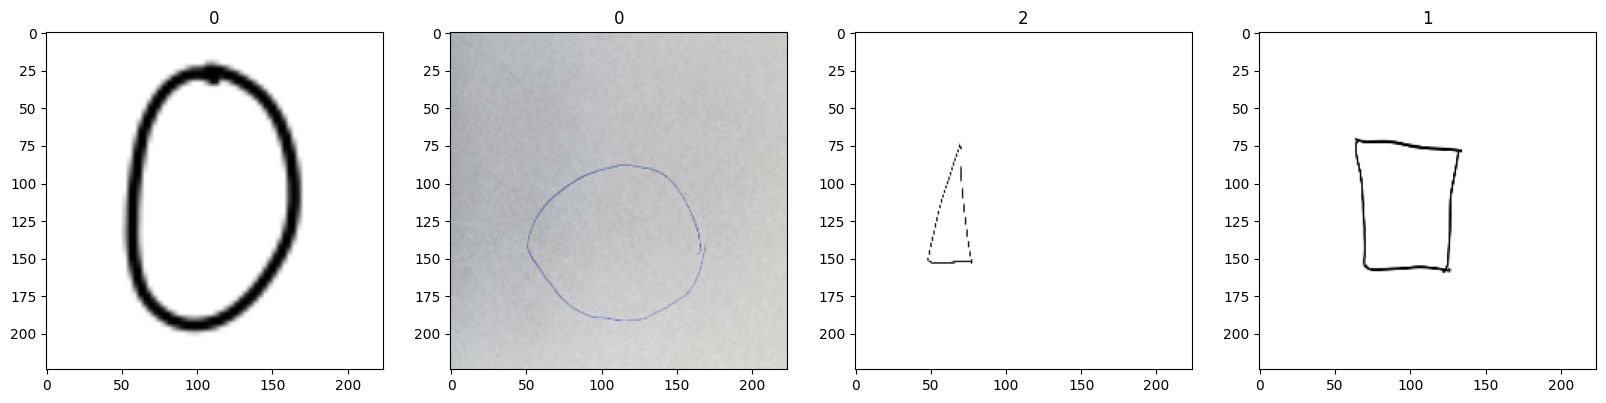

In [152]:
batch = next(iter(data))

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.numpy().astype(np.float32))  
    ax[idx].title.set_text(batch[1][idx].numpy())

In [153]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [154]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.2),
])

In [165]:
model = tf.keras.Sequential([
    data_augmentation,
    
    tf.keras.layers.Conv2D(32, (3, 3),activation='relu',input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3),activation='relu',input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3),activation='relu',input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(256, (3, 3),activation='relu',input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation='softmax') 
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [166]:
y = [0] * 532 + [1] * 542 + [2] * 501
weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1 ,2]), y=y)
weights = np.log(1 + weights)
weights /= np.mean(weights)
class_weights = {i: round(w, 4) for i, w in enumerate(weights)}
print(class_weights)

{0: 0.9899, 1: 0.9766, 2: 1.0335}


In [167]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.3)
]

In [168]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [169]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,830,089 (37.50 MB)

 Trainable params: 9,829,129 (37.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [170]:
history = model.fit(
    train,
    validation_data=val,
    epochs=40,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.3707 - loss: 11.1346 - val_accuracy: 0.2812 - val_loss: 5.9694 - learning_rate: 0.0010
Epoch 2/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.4788 - loss: 9.1864 - val_accuracy: 0.3344 - val_loss: 18.9472 - learning_rate: 0.0010
Epoch 3/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.5036 - loss: 4.5052 - val_accuracy: 0.4219 - val_loss: 1.6624 - learning_rate: 0.0010
Epoch 4/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.5438 - loss: 2.6103 - val_accuracy: 0.3438 - val_loss: 1.3380 - learning_rate: 0.0010
Epoch 5/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.5762 - loss: 1.3356 - val_accuracy: 0.3688 - val_loss: 1.1098 - learning_rate: 0.0010
Epoch 6/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.5911 - loss: 1.0470 - val_accuracy: 0.3375 - val_loss: 1.2832 - learning_rate: 0.0010
Epoch 7/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.5670 - loss: 0.9416

In [171]:
train_results = model.evaluate(train)  
train_loss = train_results[0]  
train_accuracy = train_results[1]
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Train Loss: {train_loss:.2f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8932 - loss: 0.2806
Train Accuracy: 0.89
Train Loss: 0.30


In [172]:
test_results = model.evaluate(test)  
test_loss = test_results[0]  
test_accuracy = test_results[1]
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8330 - loss: 0.3753
Test Accuracy: 0.83
Test Loss: 0.40


In [173]:
y_true = []
y_pred = []

for images, labels in test:
    preds = model.predict(images)
    pred_classes = (preds > 0.5).astype("int32").flatten() 
    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
